<a href="https://colab.research.google.com/github/SeanSDarcy2001/CISProgrammingAssignments/blob/main/dominoRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports
import numpy as np
import random
from itertools import cycle, islice
from collections import deque

intelligence

In [2]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        #self.layer3 = nn.Linear(1024, 512)
        #self.layer4 = nn.Linear(512, 256)
        #self.layer5 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        #x = F.relu(self.layer3(x))
        #x = F.relu(self.layer4(x))
        #x = F.relu(self.layer5(x))
        return self.layer3(x)

In [4]:
#objects

class Player() :

  def __init__(self, Name, intelligent = False) :
    self.name = Name
    self.hand = []
    self.intel = False
    self.state = np.zeros((70,1))
    self.prev_state = np.zeros((70,1))
    self.prev_action = np.zeros((56,1))
    self.turn = 0
    if intelligent :
      self.intel = True
      # Get number of actions from action space
      n_actions = 56
      # Get the number of state observations
      n_observations = 56 + 14 #dominos on board plus dominos in hand plus whats on left plus whats on right
      self.policy_net = DQN(n_observations, n_actions).to(device)
      self.target_net = DQN(n_observations, n_actions).to(device)
      self.target_net.load_state_dict(self.policy_net.state_dict())
      self.LR = .001
      self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)
      self.memory = ReplayMemory(7)
      self.BATCH_SIZE = 6
      self.GAMMA = 0.99
      self.TAU = 0.005


  def optimize_model(self):
    if len(self.memory) < self.BATCH_SIZE:
        return
    transitions = self.memory.sample(self.BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    #non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          #batch.next_state)), device=device, dtype=torch.bool)

    #non_final_next_states = torch.cat([s for s in batch.next_state
                                                #if s is not None])

    non_final_next_states = torch.cat(batch.next_state[:])
    non_final_next_states = torch.reshape(non_final_next_states, [self.BATCH_SIZE, 1, 70])

    state_batch = torch.cat(batch.state[:])
    state_batch = torch.reshape(state_batch, [self.BATCH_SIZE, 1, 70])
    #print(state_batch.shape)
    action_batch = torch.cat(batch.action)
    #print(action_batch.shape)
    action_batch = torch.reshape(action_batch, [self.BATCH_SIZE, 1])
    reward_batch = torch.cat(batch.reward)

    #print(action_batch.shape)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = self.policy_net(state_batch.squeeze()).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(self.BATCH_SIZE, device=device)

    with torch.no_grad():
        next_state_values = self.target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    #print(next_state_values.shape)
    reward_batch = torch.reshape(reward_batch, [self.BATCH_SIZE, 1])
    #print(reward_batch.shape)
    expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
    self.optimizer.step()


  def obtainHand(self, sevenDominos) :
    for doms in sevenDominos :
      self.hand.append(doms)

  def displayHand(self) :
    print(self.name, " has ", str(len(self.hand)), " dominos left.")
    for doms in self.hand :
      print("%%%%%%")
      #doms.printDom()
      print(doms)

  def getValueOfHand(self) :
    value = 0
    for doms in self.hand :
      a, b = doms
      value = value + a + b
      #doms.printDom()
    print(self.name)
    print("hand value:")
    print(value)
    return value

  def placeDomino(self, board) :
    a, b = board.getEnds()
    self.state = board.getState()
    action_mask = np.zeros((56,56))
    if self.intel :



      for doms in self.hand: #update hand portion of state vector
        indexOfDomino = board.lookUpTable.index(doms)
        self.state[14 + 28 + indexOfDomino] = 1

        r, l = doms #will create an action mask
        if r == a or l == a :
          action_mask[indexOfDomino, indexOfDomino] = 1
        if r == b or l == b :
          action_mask[28 + indexOfDomino, 28 + indexOfDomino] = 1

      for i in range(56) :
        for j in range(56) :
          if action_mask[i, j] == 0 :
            action_mask[i, j] = -1*np.Inf


      state = torch.tensor(self.state, dtype=torch.float32, device=device).unsqueeze(0)

      if self.turn >= 1 :
        prev_state = torch.tensor(self.prev_state, dtype=torch.float32, device=device).unsqueeze(0)
        # Store the transition in memory
        self.memory.push(prev_state, self.prev_action, state, self.prev_reward)


        #self.optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
        self.target_net.load_state_dict(target_net_state_dict)

      with torch.no_grad():
        #print(self.policy_net(state.squeeze()).unsqueeze(0).shape)
        actions = torch.matmul(self.policy_net(state.squeeze()).unsqueeze(0), torch.tensor(action_mask, dtype=torch.float32, device=device))

        action = torch.argmax(actions)
        #actionValue = torch.max(actions)

      #print(action)
      #print(actionValue)

      #assuming action of index of max neuron for now
      placed = 0
      if action < 28 :
        dominoToPlace = board.lookUpTable[action ]
        if dominoToPlace in self.hand :
          placed = board.addDomino(dominoToPlace, "L")
          self.hand.remove(dominoToPlace)
          reward = (dominoToPlace[0] + dominoToPlace[1]) / 12
          if len(self.hand) == 0 :
            reward = 1
        else :
          reward = -1
      elif action >= 28 :
        dominoToPlace = board.lookUpTable[action - 28]
        if dominoToPlace in self.hand :
          placed = board.addDomino(dominoToPlace, "R")
          self.hand.remove(dominoToPlace)
          reward = (dominoToPlace[0] + dominoToPlace[1]) / 12
          if len(self.hand) == 0 :
            reward = 1
        else :
          reward = -1
      else :
        reward = -1

      if placed == 0 :
        for doms in self.hand :
          val1, val2 = doms
          if val1 == a :
            board.addDomino(doms, "L")
            self.hand.remove(doms)
            return 1
          elif val1 == b :
            board.addDomino(doms, "R")
            self.hand.remove(doms)
            return 1
          elif val2 == a  :
            board.addDomino(doms, "L")
            self.hand.remove(doms)
            return 1
          elif val2 == b :
            board.addDomino(doms, "R")
            self.hand.remove(doms)
            return 1


      reward = torch.tensor([reward], device=device)

      self.prev_state = self.state
      self.prev_reward = reward
      print(torch.argmax(actions))
      self.prev_action = torch.argmax(actions).unsqueeze(0)
      self.turn += 1



      #this will be sent to q-net for action inference

    else :
      for doms in self.hand :
        val1, val2 = doms
        if val1 == a :
          board.addDomino(doms, "L")
          self.hand.remove(doms)
          return 1
        elif val1 == b :
          board.addDomino(doms, "R")
          self.hand.remove(doms)
          return 1
        elif val2 == a  :
          board.addDomino(doms, "L")
          self.hand.remove(doms)
          return 1
        elif val2 == b :
          board.addDomino(doms, "R")
          self.hand.remove(doms)
          return 1
    return 0



class Board() :
  def __init__(self, firstDomino) :
    self.board = deque()
    self.left, self.right = firstDomino
    self.lookUpTable = DominoSet().box


  def addDomino(self, domino, side) :
    a, b = domino
    if side == "R" :
      if self.right == a :
        self.board.append(domino)
        self.right = b
        return 1
      elif self.right == b :
        self.board.append(domino)
        self.right = a
        return 1
      else :
        print("Invalid move")
        return 0
    elif side == "L" :
      if self.left == a :
        self.board.appendleft(domino)
        self.left = b
        return 1
      elif self.left == b :
        self.board.appendleft(domino)
        self.left = a
        return 1
      else :
        print("Invalid move")
        return 0

  def getEnds(self) :
    return self.left, self.right

  def getState(self) :
    #dominoL = self.board[0]
    #dominoR = self.board[-1]
    #a, c = dominoA.getVals() #care about a from a
    #d, b = dominoB.getVals() #care about b from b
    state = np.zeros((70,1)) #create state vector
    for doms in self.board:
      indexOfDomino = self.lookUpTable.index(doms)
      state[14 + indexOfDomino] = 1
    state[self.left] = 1
    state[7 + self.right] = 1
    return state

class Domino() :

  def __init__(self, a, b) :
    self.val1 = a
    self.val2 = b

  def printDom(self) :
    print(self.val1)
    print("=")
    print(self.val2)

  def getVals(self) :
    return self.val1, self.val2

class DominoSet() :
  def __init__(self) :
    self.box = []
    for i in range(7) :
      for j in range(7) :
        if j >= i :
          self.box.append((i, j))

  def printBox(self) :
    for doms in self.box :
      print("%%%%%%")
      #doms.printDom()
      print(doms)

  def giveToPlayer(self) :
    playerDoms = []
    for k in range(7) :
      random_dom = random.choice(self.box)
      self.box.remove(random_dom)
      playerDoms.append(random_dom)
    return playerDoms

class gameSimulation() :


  def __init__(self, playersInGame, playerOfInterest) :
    self.players = playersInGame
    dominos = DominoSet()
    self.gameState = np.zeros((70,1))
    self.gameAction = np.zeros((56,1))
    self.playerOfInt = playerOfInterest

    for player in self.players :
      fromBox = dominos.giveToPlayer() #gets 7 seven random dominos
      for doms in fromBox : #checks whos got the 6\\6
        if doms == (6, 6) :
          self.startingPlayer = player
          self.gameBoard = Board(doms)
          fromBox.remove(doms)
      player.obtainHand(fromBox) #gives dominos to player


    #reorder player list based on starting player
    print(self.startingPlayer.name)
    print("starts.")
    indexOfPlayer = self.players.index(self.startingPlayer) + 1
    if indexOfPlayer == len(self.players) :
      indexOfPlayer = 0
    self.players = self.reorder_players(indexOfPlayer)

  def reorder_players(self, index):
    if index >= len(self.players):
        return self.players  # Index out of range, return the original list
    # Split the list into two parts
    first_part = self.players[:index]
    second_part = self.players[index:]
    # Concatenate the second part with the first part
    reordered_lst = second_part + first_part
    return reordered_lst


  def runGame(self) :
    running = True
    played = [1, 1, 1, 1]
    counter = 0
    for player in cycle(self.players) :

      print(self.gameBoard.getEnds())


      if running == False : #terminal condition for once game ends
        break
      print("=============")

      player.displayHand()
      played[counter] = player.placeDomino(self.gameBoard) #will return 0 if player passes


      print(played[counter])
      counter += 1
      if counter == len(self.players) :
        counter = 0

      if len(player.hand) == 0 :
        print(player.name)
        print("wins.")
        running = False
        handValues = [0, 0, 0, 0]
        for i, remaining in enumerate(self.players) :
          handValues[i] = remaining.getValueOfHand()
        points = np.sum(handValues)
        print(points)
        print("points earned.")
        if player.name == self.playerOfInt :
          print("=============")
          return 1
        else :
          print("=============")
          return 0

      if played == [0, 0, 0, 0] :
        print("se cerro.")
        running = False
        handValues = [0, 0, 0, 0]
        for i, remaining in enumerate(self.players) :
          handValues[i] = remaining.getValueOfHand()
        winner = np.argmin(handValues)
        print(self.players[winner].name)
        print("wins.")
        if self.players[winner].name == self.playerOfInt :
          print("=============")
          return 1
        else :
          print("=============")
          return 0






  def resetGame(self) :
    for plyr in self.players :
      plyr.hand = []






Gordo
starts.
(6, 6)
Seby  has  7  dominos left.
%%%%%%
(2, 2)
%%%%%%
(3, 5)
%%%%%%
(1, 5)
%%%%%%
(1, 2)
%%%%%%
(3, 3)
%%%%%%
(5, 5)
%%%%%%
(2, 6)
1
(2, 6)
Mino  has  7  dominos left.
%%%%%%
(0, 0)
%%%%%%
(0, 6)
%%%%%%
(4, 5)
%%%%%%
(2, 3)
%%%%%%
(3, 6)
%%%%%%
(0, 3)
%%%%%%
(2, 5)
1
(2, 0)
Tita  has  7  dominos left.
%%%%%%
(4, 4)
%%%%%%
(5, 6)
%%%%%%
(1, 4)
%%%%%%
(1, 6)
%%%%%%
(1, 3)
%%%%%%
(1, 1)
%%%%%%
(4, 6)
0
(2, 0)
Gordo  has  6  dominos left.
%%%%%%
(0, 2)
%%%%%%
(2, 4)
%%%%%%
(0, 4)
%%%%%%
(3, 4)
%%%%%%
(0, 1)
%%%%%%
(0, 5)
1
(2, 2)
Seby  has  6  dominos left.
%%%%%%
(2, 2)
%%%%%%
(3, 5)
%%%%%%
(1, 5)
%%%%%%
(1, 2)
%%%%%%
(3, 3)
%%%%%%
(5, 5)
1
(2, 2)
Mino  has  6  dominos left.
%%%%%%
(0, 0)
%%%%%%
(4, 5)
%%%%%%
(2, 3)
%%%%%%
(3, 6)
%%%%%%
(0, 3)
%%%%%%
(2, 5)
1
(3, 2)
Tita  has  7  dominos left.
%%%%%%
(4, 4)
%%%%%%
(5, 6)
%%%%%%
(1, 4)
%%%%%%
(1, 6)
%%%%%%
(1, 3)
%%%%%%
(1, 1)
%%%%%%
(4, 6)
1
(1, 2)
Gordo  has  5  dominos left.
%%%%%%
(2, 4)
%%%%%%
(0, 4)
%%%%%%
(3, 4)
%%%%

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([6, 1, 56])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Streaming output truncated to the last 5000 lines.
(1, 1)
1
(6, 2)
Seby  has  1  dominos left.
%%%%%%
(5, 6)
1
Seby
wins.
Mino
hand value:
7
Tita
hand value:
0
Gordo
hand value:
10
Seby
hand value:
0
17
points earned.
Gordo
starts.
(6, 6)
Seby  has  7  dominos left.
%%%%%%
(2, 2)
%%%%%%
(0, 1)
%%%%%%
(2, 3)
%%%%%%
(0, 5)
%%%%%%
(0, 3)
%%%%%%
(1, 5)
%%%%%%
(3, 6)
1
(3, 6)
Mino  has  7  dominos left.
%%%%%%
(4, 4)
%%%%%%
(1, 2)
%%%%%%
(1, 1)
%%%%%%
(0, 6)
%%%%%%
(1, 3)
%%%%%%
(2, 4)
%%%%%%
(4, 6)
1
(3, 0)
Tita  has  7  dominos left.
%%%%%%
(2, 5)
%%%%%%
(3, 3)
%%%%%%
(3, 5)
%%%%%%
(1, 6)
%%%%%%
(3, 4)
%%%%%%
(2, 6)
%%%%%%
(0, 0)
1
(3, 0)
Gordo  has  6  dominos left.
%%%%%%
(0, 4)
%%%%%%
(1, 4)
%%%%%%
(5, 5)
%%%%%%
(5, 6)
%%%%%%
(4, 5)
%%%%%%
(0, 2)
1
(3, 4)
Seby  has  6  dominos left.
%%%%%%
(2, 2)
%%%%%%
(0, 1)
%%%%%%
(2, 3)
%%%%%%
(0, 5)
%%%%%%
(0, 3)
%%%%%%
(1, 5)
1
(2, 4)
Mino  has  6  dominos left.
%%%%%%
(4, 4)
%%%%%%
(1, 2)
%%%%%%
(1, 1)
%%%%%%
(1, 3)
%%%%%%
(2, 4)
%%%%%%
(4, 6)
1

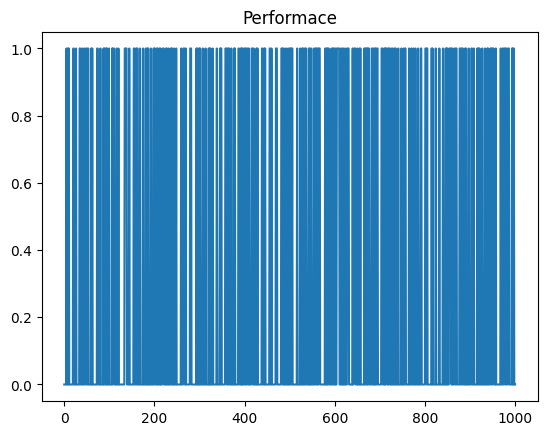

In [5]:
players = [Player("Seby", intelligent=True), Player("Mino"), Player("Tita"), Player("Gordo")]

if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 100

performance = []
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    sim = gameSimulation(players, "Seby")
    performance.append(sim.runGame())
    players[0].optimize_model()
    sim.resetGame()

plt.figure()
plt.plot(np.linspace(0, num_episodes, num_episodes), performance)
plt.title("Performace")

accuracy = np.sum(performance) / num_episodes
print(accuracy)

std = np.sqrt(accuracy*(1-accuracy)/num_episodes)
print(std)
smartSeby = players[0]

Streaming output truncated to the last 5000 lines.
1
(2, 6)
Gordo  has  7  dominos left.
%%%%%%
(0, 1)
%%%%%%
(0, 6)
%%%%%%
(2, 5)
%%%%%%
(0, 0)
%%%%%%
(0, 3)
%%%%%%
(0, 4)
%%%%%%
(3, 6)
Invalid move
1
(2, 0)
Seby  has  7  dominos left.
%%%%%%
(0, 2)
%%%%%%
(2, 3)
%%%%%%
(4, 4)
%%%%%%
(4, 5)
%%%%%%
(0, 5)
%%%%%%
(5, 6)
%%%%%%
(2, 4)
1
(2, 2)
Mino  has  6  dominos left.
%%%%%%
(3, 4)
%%%%%%
(3, 3)
%%%%%%
(4, 6)
%%%%%%
(3, 5)
%%%%%%
(1, 6)
%%%%%%
(1, 2)
1
(1, 2)
Tita  has  6  dominos left.
%%%%%%
(1, 5)
%%%%%%
(1, 3)
%%%%%%
(1, 4)
%%%%%%
(1, 1)
%%%%%%
(2, 2)
%%%%%%
(5, 5)
1
(5, 2)
Gordo  has  5  dominos left.
%%%%%%
(0, 1)
%%%%%%
(2, 5)
%%%%%%
(0, 3)
%%%%%%
(0, 4)
%%%%%%
(3, 6)
1
(5, 5)
Seby  has  6  dominos left.
%%%%%%
(2, 3)
%%%%%%
(4, 4)
%%%%%%
(4, 5)
%%%%%%
(0, 5)
%%%%%%
(5, 6)
%%%%%%
(2, 4)
1
(4, 5)
Mino  has  5  dominos left.
%%%%%%
(3, 4)
%%%%%%
(3, 3)
%%%%%%
(4, 6)
%%%%%%
(3, 5)
%%%%%%
(1, 6)
1
(3, 5)
Tita  has  5  dominos left.
%%%%%%
(1, 3)
%%%%%%
(1, 4)
%%%%%%
(1, 1)
%%%%%%
(

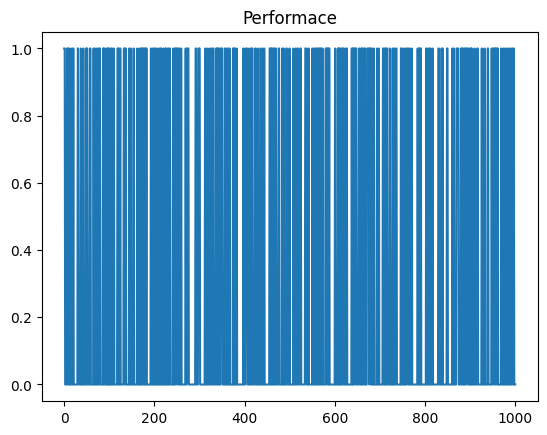

In [6]:
players[3] = Player("Gordo", intelligent = True) #now add another intelligent player

if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 100

performance = []
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    sim = gameSimulation(players, "Gordo")
    performance.append(sim.runGame())
    players[3].optimize_model()
    sim.resetGame()

plt.figure()
plt.plot(np.linspace(0, num_episodes, num_episodes), performance)
plt.title("Performace")

accuracy = np.sum(performance) / num_episodes
print(accuracy)

std = np.sqrt(accuracy*(1-accuracy)/num_episodes)
print(std)
smartGordo = players[3]

Streaming output truncated to the last 5000 lines.
(2, 5)
Seby  has  4  dominos left.
%%%%%%
(0, 1)
%%%%%%
(0, 2)
%%%%%%
(1, 1)
%%%%%%
(2, 3)
1
(0, 5)
Mino  has  2  dominos left.
%%%%%%
(0, 3)
%%%%%%
(3, 3)
1
(3, 5)
Tita  has  1  dominos left.
%%%%%%
(1, 2)
tensor(0, device='cuda:0')
0
(3, 5)
Gordo  has  1  dominos left.
%%%%%%
(0, 5)
1
Gordo
wins.
Gordo
hand value:
0
Seby
hand value:
8
Mino
hand value:
6
Tita
hand value:
3
17
points earned.
Gordo
starts.
(6, 6)
Seby  has  7  dominos left.
%%%%%%
(3, 6)
%%%%%%
(2, 4)
%%%%%%
(0, 2)
%%%%%%
(1, 2)
%%%%%%
(2, 2)
%%%%%%
(0, 5)
%%%%%%
(3, 5)
1
(3, 6)
Mino  has  7  dominos left.
%%%%%%
(4, 4)
%%%%%%
(0, 0)
%%%%%%
(5, 5)
%%%%%%
(4, 6)
%%%%%%
(3, 4)
%%%%%%
(2, 6)
%%%%%%
(5, 6)
1
(3, 4)
Tita  has  7  dominos left.
%%%%%%
(1, 4)
%%%%%%
(2, 5)
%%%%%%
(1, 1)
%%%%%%
(1, 3)
%%%%%%
(0, 3)
%%%%%%
(2, 3)
%%%%%%
(4, 5)
1
(3, 1)
Gordo  has  6  dominos left.
%%%%%%
(3, 3)
%%%%%%
(0, 1)
%%%%%%
(1, 6)
%%%%%%
(0, 6)
%%%%%%
(1, 5)
%%%%%%
(0, 4)
1
(3, 1)
Seby  

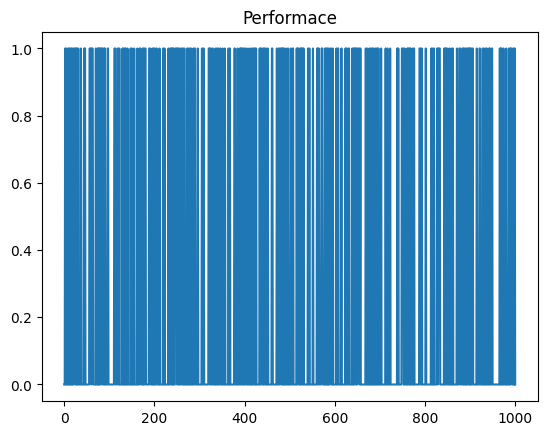

In [7]:
players[2] = Player("Tita", intelligent = True) #now add another intelligent player

if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 500

performance = []
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    sim = gameSimulation(players, "Tita")
    performance.append(sim.runGame())
    players[2].optimize_model()
    sim.resetGame()

plt.figure()
plt.plot(np.linspace(0, num_episodes, num_episodes), performance)
plt.title("Performace")
accuracy = np.sum(performance) / num_episodes
print(accuracy)

std = np.sqrt(accuracy*(1-accuracy)/num_episodes)
print(std)

smartTita = players[2]

Streaming output truncated to the last 5000 lines.
%%%%%%
(0, 4)
%%%%%%
(2, 2)
%%%%%%
(3, 3)
1
(1, 3)
Mino  has  5  dominos left.
%%%%%%
(4, 4)
%%%%%%
(2, 4)
%%%%%%
(2, 6)
%%%%%%
(1, 1)
%%%%%%
(5, 5)
1
(1, 3)
Tita  has  5  dominos left.
%%%%%%
(0, 1)
%%%%%%
(2, 5)
%%%%%%
(1, 3)
%%%%%%
(3, 6)
%%%%%%
(0, 2)
1
(0, 3)
Gordo  has  5  dominos left.
%%%%%%
(0, 5)
%%%%%%
(4, 5)
%%%%%%
(0, 0)
%%%%%%
(5, 6)
%%%%%%
(0, 6)
1
(5, 3)
Seby  has  5  dominos left.
%%%%%%
(1, 4)
%%%%%%
(0, 3)
%%%%%%
(0, 4)
%%%%%%
(2, 2)
%%%%%%
(3, 3)
1
(5, 0)
Mino  has  4  dominos left.
%%%%%%
(4, 4)
%%%%%%
(2, 4)
%%%%%%
(2, 6)
%%%%%%
(5, 5)
1
(5, 0)
Tita  has  4  dominos left.
%%%%%%
(2, 5)
%%%%%%
(1, 3)
%%%%%%
(3, 6)
%%%%%%
(0, 2)
1
(2, 0)
Gordo  has  4  dominos left.
%%%%%%
(4, 5)
%%%%%%
(0, 0)
%%%%%%
(5, 6)
%%%%%%
(0, 6)
1
(2, 0)
Seby  has  4  dominos left.
%%%%%%
(1, 4)
%%%%%%
(0, 4)
%%%%%%
(2, 2)
%%%%%%
(3, 3)
1
(2, 4)
Mino  has  3  dominos left.
%%%%%%
(4, 4)
%%%%%%
(2, 4)
%%%%%%
(2, 6)
1
(2, 4)
Tita  has  3  dom

Text(0.5, 1.0, 'Performace')

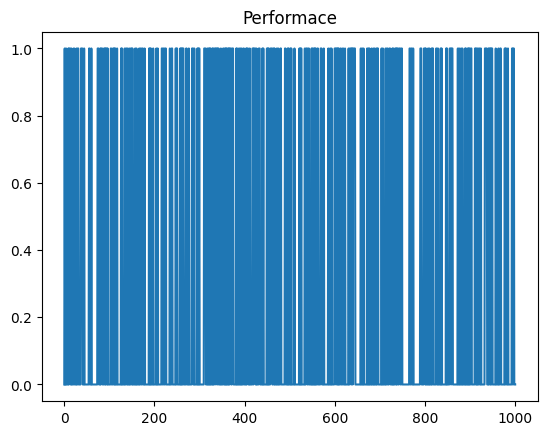

In [8]:
players = [Player("Seby"), Player("Mino"), smartTita, Player("Gordo")] #now trained 3x Tita (1x seby and 2x gordo), vs 3 bots, performance should be highest

if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 100

performance = []
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    sim = gameSimulation(players, "Tita")
    performance.append(sim.runGame())
    sim.resetGame()

plt.figure()
plt.plot(np.linspace(0, num_episodes, num_episodes), performance)
plt.title("Performace")

In [9]:
accuracy = np.sum(performance) / num_episodes
print(accuracy)

std = np.sqrt(accuracy*(1-accuracy)/num_episodes)
print(std)

0.317
0.014714312760030624


Streaming output truncated to the last 5000 lines.
(2, 4)
Gordo  has  2  dominos left.
%%%%%%
(2, 5)
%%%%%%
(4, 5)
1
(5, 4)
Seby  has  2  dominos left.
%%%%%%
(0, 2)
%%%%%%
(2, 3)
tensor(0, device='cuda:0')
0
(5, 4)
BOSS  has  1  dominos left.
%%%%%%
(4, 4)
1
BOSS
wins.
Tita
hand value:
19
Gordo
hand value:
9
Seby
hand value:
7
BOSS
hand value:
0
35
points earned.
Seby
starts.
(6, 6)
BOSS  has  7  dominos left.
%%%%%%
(1, 6)
%%%%%%
(1, 3)
%%%%%%
(3, 5)
%%%%%%
(1, 1)
%%%%%%
(0, 5)
%%%%%%
(2, 2)
%%%%%%
(5, 5)
1
(1, 6)
Tita  has  7  dominos left.
%%%%%%
(2, 6)
%%%%%%
(3, 4)
%%%%%%
(4, 4)
%%%%%%
(2, 5)
%%%%%%
(1, 2)
%%%%%%
(0, 1)
%%%%%%
(1, 4)
1
(1, 2)
Gordo  has  7  dominos left.
%%%%%%
(3, 6)
%%%%%%
(0, 3)
%%%%%%
(5, 6)
%%%%%%
(0, 0)
%%%%%%
(2, 3)
%%%%%%
(4, 6)
%%%%%%
(4, 5)
Invalid move
1
(1, 3)
Seby  has  6  dominos left.
%%%%%%
(1, 5)
%%%%%%
(2, 4)
%%%%%%
(3, 3)
%%%%%%
(0, 6)
%%%%%%
(0, 2)
%%%%%%
(0, 4)
1
(5, 3)
BOSS  has  6  dominos left.
%%%%%%
(1, 3)
%%%%%%
(3, 5)
%%%%%%
(1, 1)
%%%

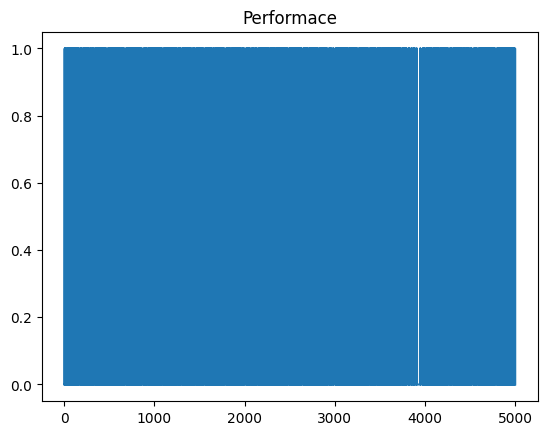

In [10]:
players = [Player("BOSS", intelligent = True), smartTita, smartGordo, smartSeby]
if torch.cuda.is_available():
    num_episodes = 5000
else:
    num_episodes = 100

performance = []
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    sim = gameSimulation(players, "BOSS")
    players[0].optimize_model()
    performance.append(sim.runGame())
    sim.resetGame()

plt.figure()
plt.plot(np.linspace(0, num_episodes, num_episodes), performance)
plt.title("Performace")

accuracy = np.sum(performance) / num_episodes
print(accuracy)

std = np.sqrt(accuracy*(1-accuracy)/num_episodes)
print(std)
BOSS = players[0]

Streaming output truncated to the last 5000 lines.
1
(3, 2)
p3  has  6  dominos left.
%%%%%%
(2, 5)
%%%%%%
(1, 3)
%%%%%%
(4, 5)
%%%%%%
(0, 6)
%%%%%%
(1, 1)
%%%%%%
(1, 5)
1
(3, 5)
BOSS  has  6  dominos left.
%%%%%%
(3, 6)
%%%%%%
(4, 6)
%%%%%%
(3, 3)
%%%%%%
(4, 4)
%%%%%%
(0, 5)
%%%%%%
(1, 4)
1
(6, 5)
p1  has  6  dominos left.
%%%%%%
(2, 2)
%%%%%%
(0, 0)
%%%%%%
(5, 5)
%%%%%%
(1, 6)
%%%%%%
(0, 3)
%%%%%%
(0, 4)
1
(6, 5)
p2  has  6  dominos left.
%%%%%%
(0, 2)
%%%%%%
(0, 1)
%%%%%%
(2, 4)
%%%%%%
(1, 2)
%%%%%%
(2, 3)
%%%%%%
(3, 4)
0
(6, 5)
p3  has  5  dominos left.
%%%%%%
(1, 3)
%%%%%%
(4, 5)
%%%%%%
(0, 6)
%%%%%%
(1, 1)
%%%%%%
(1, 5)
1
(6, 4)
BOSS  has  5  dominos left.
%%%%%%
(4, 6)
%%%%%%
(3, 3)
%%%%%%
(4, 4)
%%%%%%
(0, 5)
%%%%%%
(1, 4)
1
(6, 6)
p1  has  5  dominos left.
%%%%%%
(2, 2)
%%%%%%
(0, 0)
%%%%%%
(1, 6)
%%%%%%
(0, 3)
%%%%%%
(0, 4)
1
(1, 6)
p2  has  6  dominos left.
%%%%%%
(0, 2)
%%%%%%
(0, 1)
%%%%%%
(2, 4)
%%%%%%
(1, 2)
%%%%%%
(2, 3)
%%%%%%
(3, 4)
1
(0, 6)
p3  has  4  dominos left.


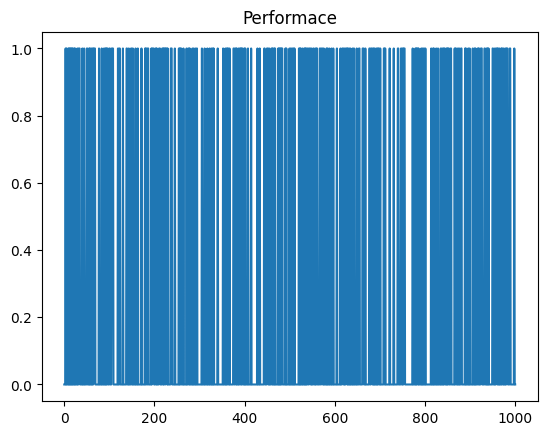

In [11]:
smartBOSS = players[0]

players = [smartBOSS, Player("p1"), Player("p2"), Player("p3")] #now trained 4x Boss (1x seby, 2x gordo, 3x Tita, 5000times), vs 3 bots, performance should be highest

if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 100

performance = []
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    sim = gameSimulation(players, "BOSS")
    performance.append(sim.runGame())
    sim.resetGame()

plt.figure()
plt.plot(np.linspace(0, num_episodes, num_episodes), performance)
plt.title("Performace")

accuracy = np.sum(performance) / num_episodes
print(accuracy)

std = np.sqrt(accuracy*(1-accuracy)/num_episodes)
print(std)
BOSS = players[0]

In [28]:
fname = "/content/outputs/savedTita.txt"
import pickle
import json
from pathlib import Path


fileHandler = open(fname, "wb")
print("Dumping with pickle:")
pickle.dump(smartTita, fileHandler)

Dumping with pickle:


In [29]:
fname = "/content/outputs/savedBOSS.txt"
import pickle
import json
from pathlib import Path


fileHandler = open(fname, "wb")
print("Dumping with pickle:")
pickle.dump(smartBOSS, fileHandler)

Dumping with pickle:
